# Mustererkennung in Funkmessdaten

## Aufgabe 1: Laden der Datenbank in Jupyter Notebook

In [24]:
# imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pp

Wir öffnen die Datenbank und lassen uns die Keys der einzelnen Tabellen ausgeben. 
 

In [25]:
hdf = pd.HDFStore('../../data/raw/TestMessungen_NEU.hdf')
print(hdf.keys)

<bound method HDFStore.keys of <class 'pandas.io.pytables.HDFStore'>
File path: ../../data/raw/TestMessungen_NEU.hdf
/x1/t1/trx_1_2            frame        (shape->[227,12009])
/x1/t1/trx_1_4            frame        (shape->[229,12009])
/x1/t1/trx_2_3            frame        (shape->[226,12009])
/x1/t1/trx_3_1            frame        (shape->[233,12009])
/x1/t1/trx_3_4            frame        (shape->[226,12009])
/x1/t1/trx_4_2            frame        (shape->[230,12009])
/x1/t2/trx_1_2            frame        (shape->[223,12009])
/x1/t2/trx_1_4            frame        (shape->[220,12009])
/x1/t2/trx_2_3            frame        (shape->[218,12009])
/x1/t2/trx_3_1            frame        (shape->[221,12009])
/x1/t2/trx_3_4            frame        (shape->[218,12009])
/x1/t2/trx_4_2            frame        (shape->[221,12009])
/x1/t3/trx_1_2            frame        (shape->[246,12009])
/x1/t3/trx_1_4            frame        (shape->[250,12009])
/x1/t3/trx_2_3            frame        (sha

## Aufgabe 2: Inspektion eines einzelnen Dataframes

Wir laden den Frame x1_t1_trx_1_4 und betrachten seine Dimension. 

In [26]:
df_x1_t1_trx_1_4 = hdf.get('/x1/t1/trx_1_4')
print("Rows:", df_x1_t1_trx_1_4.shape[0])
print("Columns:", df_x1_t1_trx_1_4.shape[1])

Rows: 229
Columns: 12009


Als nächstes Untersuchen wir exemplarisch für zwei Empfänger-Sender-Gruppen die Attributzusammensetzung.

In [27]:
# first inspection of columns from df_x1_t1_trx_1_4
df_x1_t1_trx_1_4.head(5)

,index,Timestamp,trx_1_4_ifft_0,trx_1_4_ifft_1,trx_1_4_ifft_2,trx_1_4_ifft_3,trx_1_4_ifft_4,trx_1_4_ifft_5,trx_1_4_ifft_6,trx_1_4_ifft_7,...,trx_4_1_ifft_1992,trx_4_1_ifft_1993,trx_4_1_ifft_1994,trx_4_1_ifft_1995,trx_4_1_ifft_1996,trx_4_1_ifft_1997,trx_4_1_ifft_1998,trx_4_1_ifft_1999,trx_4_1_ts,target
0,0,1.492291e+09,0.021636,0.021845,0.022040,0.022221,0.022388,0.022540,0.022677,0.022798,...,0.013412,0.012879,0.012468,0.012188,0.012047,0.012049,0.012190,0.012462,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
1,1,1.492291e+09,0.020806,0.020952,0.021081,0.021192,0.021287,0.021363,0.021422,0.021462,...,0.015530,0.015678,0.015933,0.016286,0.016729,0.017254,0.017849,0.018505,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
2,2,1.492291e+09,0.030507,0.030675,0.030819,0.030940,0.031038,0.031111,0.031160,0.031184,...,0.010804,0.010567,0.010535,0.010708,0.011072,0.011607,0.012286,0.013082,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
3,3,1.492291e+09,0.027926,0.028066,0.028187,0.028288,0.028369,0.028430,0.028470,0.028489,...,0.018073,0.017580,0.017163,0.016826,0.016573,0.016408,0.016331,0.016341,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"
4,4,1.492291e+09,0.021023,0.021285,0.021528,0.021752,0.021956,0.022141,0.022305,0.022449,...,0.016200,0.016055,0.016017,0.016085,0.016256,0.016524,0.016882,0.017323,1.488963e+12,"Empty_0.0,0.0_0.0,0.0"


Für die Analyse der Frames definieren wir einige Hilfsfunktionen.

In [28]:
# Little function to retrieve sender-receiver tuples from df columns
def extract_snd_rcv(df):
    regex = r"trx_[1-4]_[1-4]"
    # creates a set containing the different pairs
    snd_rcv = {x[4:7] for x in df.columns if re.search(regex, x)}
    return [(x[0],x[-1]) for x in snd_rcv]

In [29]:
# Sums the number of columns for each sender-receiver tuple
def get_column_counts(snd_rcv, df):
    col_counts = {}
    for snd,rcv in snd_rcv:
        col_counts['Columns for pair {} {}:'.format(snd, rcv)] = len([i for i, word in enumerate(list(df.columns)) if word.startswith('trx_{}_{}'.format(snd, rcv))])
    return col_counts

In [30]:
# Analyze the column composition of a given measurement.
def analyse_columns(df):
    df_snd_rcv = extract_snd_rcv(df)
    cc = get_column_counts(df_snd_rcv, df)

    for x in cc:
        print(x, cc[x])
    print("Sum of pair related columns: %i" % sum(cc.values()))
    print()
    print("Other columns are:")
    for att in [col for col in df.columns if 'ifft' not in col and 'ts' not in col]:
        print(att)

In [31]:
# Analyze the values of the target column.
def analyze_target(df):
    print(df['target'].unique())
    print("# Unique values in target: %i" % len(df['target'].unique()))

Bestimme nun die Spaltezusammensetzung von df_x1_t1_trx_1_4.

In [32]:
analyse_columns(df_x1_t1_trx_1_4)

Columns for pair 2 1: 2001
Columns for pair 4 1: 2001
Columns for pair 2 4: 2001
Columns for pair 3 1: 2001
Columns for pair 3 4: 2001
Columns for pair 1 4: 2001
Sum of pair related columns: 12006

Other columns are:
index
Timestamp
target


Betrachte den Inhalt der "target"-Spalte von df_x1_t1_trx_1_4.

In [33]:
analyze_target(df_x1_t1_trx_1_4)

['Empty_0.0,0.0_0.0,0.0' 'Standing_1.0,1.0_1.0,1.0' 'Step_1.0,1.0_1.0,2.0'
 'Standing_1.0,2.0_1.0,2.0' 'Step_1.0,2.0_2.0,2.0'
 'Standing_2.0,2.0_2.0,2.0' 'Step_2.0,2.0_2.0,1.0'
 'Standing_2.0,1.0_2.0,1.0' 'Step_2.0,1.0_1.0,1.0'
 'Walking_0.0,0.0_0.0,0.0']
# Unique values in target: 10


Als nächstes laden wir den Frame x3_t2_trx_3_1 und betrachten seine Dimension. 

In [34]:
df_x3_t2_trx_3_1 = hdf.get('/x3/t2/trx_3_1')
print("Rows:", df_x3_t2_trx_3_1.shape[0])
print("Columns:", df_x3_t2_trx_3_1.shape[1])

Rows: 247
Columns: 12009


Gefolgt von einer Analyse seiner Spaltenzusammensetzung und seiner "target"-Werte.

In [35]:
analyse_columns(df_x3_t2_trx_3_1)

Columns for pair 4 1: 2001
Columns for pair 2 1: 2001
Columns for pair 2 3: 2001
Columns for pair 4 3: 2001
Columns for pair 3 1: 2001
Columns for pair 1 3: 2001
Sum of pair related columns: 12006

Other columns are:
index
Timestamp
target


In [36]:
analyze_target(df_x3_t2_trx_3_1)

['Empty_0.0,0.0_0.0,0.0' 'Standing_1.0,1.0_1.0,1.0' 'Step_1.0,1.0_1.0,2.0'
 'Standing_1.0,2.0_1.0,2.0' 'Step_1.0,2.0_2.0,2.0'
 'Standing_2.0,2.0_2.0,2.0' 'Step_2.0,2.0_2.0,1.0'
 'Standing_2.0,1.0_2.0,1.0' 'Step_2.0,1.0_1.0,1.0'
 'Walking_0.0,0.0_0.0,0.0']
# Unique values in target: 10


Frage: Was stellen Sie bzgl. der „Empfänger-Nummer_Sender-Nummer“-Kombinationen fest? Sind diese gleich? Welche Ausprägungen finden Sie in der Spalte „target“? 

Antwort: Wir sehen, wenn jeweils ein Paar sendet, hören die anderen beiden Sender zu und messen ihre Verbindung zu den gerade sendenden Knoten (d.h. 6 Paare in jedem Dataframe). Sendet z.B. das Paar 3 1, so misst Knoten 1 die Verbindung 1-3, Knoten 3 die Verbindung 3-1 und Knoten 2 und 4 Verbindung 2-1 und 2-3 bzw. 4-1 und 4-3. Die 10 verschiedenen Ausprägungen der Spalte "target" sind oben zu sehen.

## Aufgabe 3: Visualisierung der Messreihe des Datensatz

Wir visualisieren die Rohdaten mit verschiedenen Heatmaps, um so die Integrität der Daten optisch zu validieren und Ideen für mögliche Features zu entwickeln. Hier stellen wir exemplarisch die Daten von Frame df_x1_t1_trx_1_4 dar.

In [37]:
vals = df_x1_t1_trx_1_4.loc[:,'trx_2_4_ifft_0':'trx_2_4_ifft_1999'].values

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


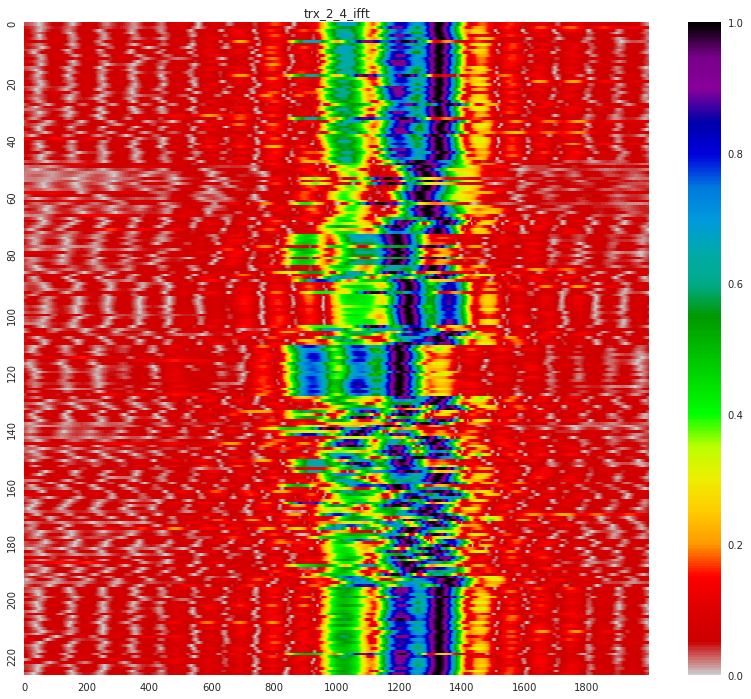

In [38]:
# one big heatmap
plt.figure(figsize=(14, 12))
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='nipy_spectral_r')
plt.show()

Wir betrachten wie verschiedene Farbschemata unterschiedliche Merkmale unserer Rohdaten hervorheben.

/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


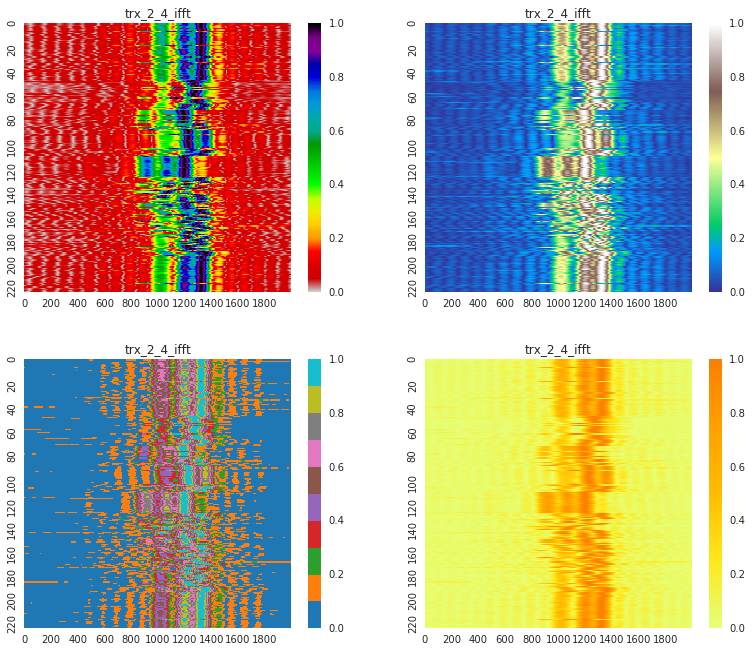

In [39]:
# compare different heatmaps
plt.figure(1, figsize=(12,10))

# nipy_spectral_r scheme
plt.subplot(221)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='nipy_spectral_r')

# terrain scheme
plt.subplot(222)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='terrain')

# Vega10 scheme
plt.subplot(223)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Vega10')

# Wistia scheme
plt.subplot(224)
plt.title('trx_2_4_ifft')
plt.xlabel("ifft of frequency")
plt.ylabel("measurement")
ax = sns.heatmap(vals, xticklabels=200, yticklabels=20, vmin=0, vmax=1, cmap='Wistia')

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.2)


plt.show()

## Aufgabe 3: Groundtruth-Label anpassen

In [40]:
# Iterating over hdf data and creating interim data presentation stored in data/interim/testmessungen_interim.hdf
# Interim data representation contains aditional binary class (binary_target - encoding 0=empty and 1=not empty)
# and multi class target (multi_target - encoding 0-9 for each possible class)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

interim_path = '../../data/interim/01_testmessungen.hdf'

def binary_mapper(df):
    
    def map_binary(target):
        if target.startswith('Empty'):
            return 0
        else:
            return 1
    
    df['binary_target'] = pd.Series(map(map_binary, df['target']))
    
    
def multiclass_mapper(df):
    le.fit(df['target'])
    df['multi_target'] = le.transform(df['target'])
    
for key in hdf.keys():
    df = hdf.get(key)
    binary_mapper(df)
    multiclass_mapper(df)
    df.to_hdf(interim_path, key)

hdf.close()

Überprüfe neu beschrifteten Dataframe „/x1/t1/trx_3_1“ verwenden. Wir erwarten als Ergebnisse für 5 zu Beginn des Experiments „Empty“ (bzw. 0) und für 120 mitten im Experiment „Not Empty“ (bzw. 1). 

In [41]:
hdf = pd.HDFStore('../../data/interim/01_testmessungen.hdf')
df_x1_t1_trx_3_1 = hdf.get('/x1/t1/trx_3_1')
print("binary_target for measurement 5:", df_x1_t1_trx_3_1['binary_target'][5])
print("binary_target for measurement 120:", df_x1_t1_trx_3_1['binary_target'][120])

print('The unique values of the target column in /x1/t1/trx_3_1 are:')
print()
print(df_x1_t1_trx_3_1["binary_target"].value_counts())
hdf.close()

binary_target for measurement 5: 0
binary_target for measurement 120: 1
The unique values of the target column in /x1/t1/trx_3_1 are:

1    151
0     82
Name: binary_target, dtype: int64


## Aufgabe 4: Einfacher Erkenner mit Hold-Out-Validierung

Wir folgen den Schritten in Aufgabe 4 und testen einen einfachen Erkenner.

In [42]:
from evaluation import *
from filters import *
from utility import *
from features import *

### Öffnen von Hdf mittels pandas

In [43]:
# raw data to achieve target values
hdf = pd.HDFStore('../../data/raw/TestMessungen_NEU.hdf')

### Beispiel Erkenner

#### Datensätze vorbereiten

In [44]:
# generate datasets
tst = ['1','2','3']
tst_ds = []

for t in tst:

    df_tst = hdf.get('/x1/t'+t+'/trx_3_1')
    lst = df_tst.columns[df_tst.columns.str.contains('_ifft_')]
    
    #df_tst_cl,_ = distortion_filter(df_tst_cl)
    
    groups = get_trx_groups(df_tst)
    df_std = rf_grouped(df_tst, groups=groups, fn=rf_std_single, label='target')
    df_mean = rf_grouped(df_tst, groups=groups, fn=rf_mean_single)
    df_p2p = rf_grouped(df_tst, groups=groups, fn=rf_ptp_single) # added p2p feature
    
    df_all = pd.concat( [df_std, df_mean, df_p2p], axis=1 ) # added p2p feature
    
    df_all = cf_std_window(df_all, window=4, label='target')
    
    df_tst_sum = generate_class_label_presence(df_all, state_variable='target')
    
    # remove index column
    df_tst_sum = df_tst_sum[df_tst_sum.columns.values[~df_tst_sum.columns.str.contains('index')].tolist()]
    print('Columns in Dataset:',t)
    print(df_tst_sum.columns)
    
    tst_ds.append(df_tst_sum.copy())

Columns in Dataset: 1
Index(['col_std_rf_std_trx_1_3_ifft_0', 'col_std_rf_std_trx_2_1_ifft_0',
       'col_std_rf_std_trx_2_3_ifft_0', 'col_std_rf_std_trx_3_1_ifft_0',
       'col_std_rf_std_trx_4_1_ifft_0', 'col_std_rf_std_trx_4_3_ifft_0',
       'col_std_rf_mean_trx_1_3_ifft_0', 'col_std_rf_mean_trx_2_1_ifft_0',
       'col_std_rf_mean_trx_2_3_ifft_0', 'col_std_rf_mean_trx_3_1_ifft_0',
       'col_std_rf_mean_trx_4_1_ifft_0', 'col_std_rf_mean_trx_4_3_ifft_0',
       'col_std_rf_ptp_trx_1_3_ifft_0', 'col_std_rf_ptp_trx_2_1_ifft_0',
       'col_std_rf_ptp_trx_2_3_ifft_0', 'col_std_rf_ptp_trx_3_1_ifft_0',
       'col_std_rf_ptp_trx_4_1_ifft_0', 'col_std_rf_ptp_trx_4_3_ifft_0',
       'target'],
      dtype='object')
Columns in Dataset: 2
Index(['col_std_rf_std_trx_1_3_ifft_0', 'col_std_rf_std_trx_2_1_ifft_0',
       'col_std_rf_std_trx_2_3_ifft_0', 'col_std_rf_std_trx_3_1_ifft_0',
       'col_std_rf_std_trx_4_1_ifft_0', 'col_std_rf_std_trx_4_3_ifft_0',
       'col_std_rf_mean_trx_1_3_if

In [45]:
# holdout validation
print(hold_out_val(tst_ds, target='target', include_self=False, cl='rf', verbose=False, random_state=1))

(0.61662994204003829, 0.13067575746487756)


### Schließen von HDF Store

In [46]:
hdf.close()

## Aufgabe 5: Eigener Erkenner

Für die Konstruktion eines eigenen Erkenners führen wir die entsprechenden Preprocessing und Mapping Schritte ausgehend von den Roddaten erneut durch und passen diese unseren Bedürfnissen an.# Load hdfs data
hdfs = pd.HDFStore("../../data/raw/henrik/TestMessungen_NEU.hdf")

In [47]:
# Load raw data
hdf = pd.HDFStore("../../data/raw/TestMessungen_NEU.hdf")

In [48]:
# Check available keys in hdf store
print(hdf.keys)

<bound method HDFStore.keys of <class 'pandas.io.pytables.HDFStore'>
File path: ../../data/raw/TestMessungen_NEU.hdf
/x1/t1/trx_1_2            frame        (shape->[227,12009])
/x1/t1/trx_1_4            frame        (shape->[229,12009])
/x1/t1/trx_2_3            frame        (shape->[226,12009])
/x1/t1/trx_3_1            frame        (shape->[233,12009])
/x1/t1/trx_3_4            frame        (shape->[226,12009])
/x1/t1/trx_4_2            frame        (shape->[230,12009])
/x1/t2/trx_1_2            frame        (shape->[223,12009])
/x1/t2/trx_1_4            frame        (shape->[220,12009])
/x1/t2/trx_2_3            frame        (shape->[218,12009])
/x1/t2/trx_3_1            frame        (shape->[221,12009])
/x1/t2/trx_3_4            frame        (shape->[218,12009])
/x1/t2/trx_4_2            frame        (shape->[221,12009])
/x1/t3/trx_1_2            frame        (shape->[246,12009])
/x1/t3/trx_1_4            frame        (shape->[250,12009])
/x1/t3/trx_2_3            frame        (sha

### Vorverarbeitung

Zuerst passen wir die Groundtruth-Label an, entfernen Zeitstempel sowie Zeilenindices und speichern die resultierenden Frames ab.

In [51]:
# Mapping groundtruth to 0-empty and 1-not empty and prepare for further preprocessing by
# removing additional timestamp columns and index column
# Storing cleaned dataframes (no index, removed _ts columns, mapped multi classes to 0-empty, 1-not empty)
# to new hdfstore to `data/interim/02_testmessungen.hdf`

hdf_path = "../../data/interim/02_tesmessungen.hdf"

In [50]:
dfs = []
for key in hdf.keys():
    df = hdf.get(key)
    #df['target'] = df['target'].map(lambda x: 0 if x.startswith("Empty") else 1)  
    # drop all time stamp columns who endswith _ts
    cols = [c for c in df.columns if not c.lower().endswith("ts")]
    df = df[cols]
    df = df.drop('Timestamp', axis=1)
    df = df.drop('index', axis=1)
    df.to_hdf(hdf_path, key)
hdf.close()

Wir sehen, dass nur noch die 6 x 2000 Messungen für die jeweiligen Paare sowie die 'target'-Werte in den resultierenden Frames enthalten sind.

In [52]:
hdf = pd.HDFStore(hdf_path)
df = hdf.get("/x1/t1/trx_1_2")
df.head()

,trx_1_2_ifft_0,trx_1_2_ifft_1,trx_1_2_ifft_2,trx_1_2_ifft_3,trx_1_2_ifft_4,trx_1_2_ifft_5,trx_1_2_ifft_6,trx_1_2_ifft_7,trx_1_2_ifft_8,trx_1_2_ifft_9,...,trx_4_2_ifft_1991,trx_4_2_ifft_1992,trx_4_2_ifft_1993,trx_4_2_ifft_1994,trx_4_2_ifft_1995,trx_4_2_ifft_1996,trx_4_2_ifft_1997,trx_4_2_ifft_1998,trx_4_2_ifft_1999,target
0,0.057569,0.057136,0.056675,0.056187,0.055674,0.055137,0.054577,0.053996,0.053397,0.052780,...,0.030560,0.030439,0.030293,0.030121,0.029925,0.029705,0.029460,0.029193,0.028902,"Empty_0.0,0.0_0.0,0.0"
1,0.047302,0.046338,0.045374,0.044412,0.043456,0.042508,0.041572,0.040651,0.039749,0.038869,...,0.036571,0.036359,0.036123,0.035864,0.035581,0.035275,0.034946,0.034596,0.034225,"Empty_0.0,0.0_0.0,0.0"
2,0.034838,0.033317,0.031765,0.030187,0.028583,0.026958,0.025314,0.023656,0.021989,0.020319,...,0.031501,0.031202,0.030878,0.030531,0.030161,0.029768,0.029353,0.028916,0.028459,"Empty_0.0,0.0_0.0,0.0"
3,0.053769,0.053513,0.053260,0.053011,0.052767,0.052529,0.052299,0.052078,0.051868,0.051670,...,0.035597,0.035503,0.035381,0.035234,0.035061,0.034861,0.034637,0.034387,0.034113,"Empty_0.0,0.0_0.0,0.0"
4,0.042299,0.041589,0.040935,0.040344,0.039823,0.039379,0.039017,0.038745,0.038566,0.038485,...,0.035293,0.034995,0.034670,0.034319,0.033942,0.033540,0.033112,0.032661,0.032187,"Empty_0.0,0.0_0.0,0.0"


In [53]:
# Step-1 repeating the previous taks 4 to get a comparable base result with the now dropped _ts and index column to improve from
# generate datasets
from evaluation import *
from filters import *
from utility import *
from features import *

def prepare_features(c, p):
    tst = ['1','2','3']
    tst_ds = []

    for t in tst:

        df_tst = hdf.get('/x'+c+'/t'+t+'/trx_'+p)

        lst = df_tst.columns[df_tst.columns.str.contains('_ifft_')]

        df_tst,_ = distortion_filter(df_tst)

        groups = get_trx_groups(df_tst)

        df_cf_mean = reduce_dim_PCA(cf_mean_window(df_tst, window=3, column_key="ifft", label=None ).fillna(0), n_comps=10)
        #df_cf_std = reduce_dim_PCA(cf_std_window(df_tst, window=3, column_key="ifft", label=None ).fillna(0), n_comps=10)
        df_cf_ptp = reduce_dim_PCA(cf_ptp(df_tst, window=3, column_key="ifft", label=None ).fillna(0), n_comps=10)
        #df_cf_kurt = reduce_dim_PCA(cf_kurt(df_tst, window=3, column_key="ifft", label=None ).fillna(0), n_comps=10)


        #df_std = rf_grouped(df_tst, groups=groups, fn=rf_std_single)
        df_mean = rf_grouped(df_tst, groups=groups, fn=rf_mean_single, label='target')
        df_p2p = rf_grouped(df_tst, groups=groups, fn=rf_ptp_single) # added p2p feature
        df_kurt = rf_grouped(df_tst, groups=groups, fn=rf_kurtosis_single)
        df_skew = rf_grouped(df_tst, groups=groups, fn=rf_skew_single)


        df_all = pd.concat( [df_mean, df_p2p, df_kurt, df_skew], axis=1 ) 

        df_all = cf_std_window(df_all, window=4, label='target')

        df_all = cf_diff(df_all, label='target')

        df_all = reduce_dim_PCA(df_all.fillna(0), n_comps=10, label='target')

        df_all = pd.concat( [df_all, df_cf_mean, df_cf_ptp], axis=1)

        df_tst_sum = generate_class_label_presence(df_all, state_variable='target')

        # remove index column
        df_tst_sum = df_tst_sum[df_tst_sum.columns.values[~df_tst_sum.columns.str.contains('index')].tolist()]

        #print('Columns in Dataset:',t)
        #print(df_tst_sum.columns)


        tst_ds.append(df_tst_sum.copy())
        
    return tst_ds

tst_ds_PCA = prepare_features(c='1', p='3_1')

In [54]:
# Printing out the columns in order to confirm that no index or timestamp column is used for prediction
# generate_class_label_presence function from utils.py module generates namely index column implicitly!
print(tst_ds_PCA[0].columns)

Index(['pca_0', 'pca_0', 'pca_0', 'pca_1', 'pca_1', 'pca_1', 'pca_2', 'pca_2',
       'pca_2', 'pca_3', 'pca_3', 'pca_3', 'pca_4', 'pca_4', 'pca_4', 'pca_5',
       'pca_5', 'pca_5', 'pca_6', 'pca_6', 'pca_6', 'pca_7', 'pca_7', 'pca_7',
       'pca_8', 'pca_8', 'pca_8', 'pca_9', 'pca_9', 'pca_9', 'target', 'pca_0',
       'pca_0', 'pca_0', 'pca_1', 'pca_1', 'pca_1', 'pca_2', 'pca_2', 'pca_2',
       'pca_3', 'pca_3', 'pca_3', 'pca_4', 'pca_4', 'pca_4', 'pca_5', 'pca_5',
       'pca_5', 'pca_6', 'pca_6', 'pca_6', 'pca_7', 'pca_7', 'pca_7', 'pca_8',
       'pca_8', 'pca_8', 'pca_9', 'pca_9', 'pca_9', 'pca_0', 'pca_0', 'pca_0',
       'pca_1', 'pca_1', 'pca_1', 'pca_2', 'pca_2', 'pca_2', 'pca_3', 'pca_3',
       'pca_3', 'pca_4', 'pca_4', 'pca_4', 'pca_5', 'pca_5', 'pca_5', 'pca_6',
       'pca_6', 'pca_6', 'pca_7', 'pca_7', 'pca_7', 'pca_8', 'pca_8', 'pca_8',
       'pca_9', 'pca_9', 'pca_9'],
      dtype='object')


In [55]:
# Evaluating different supervised learning methods provided in eval.py
# We can see that the column features have increased F1 score of the classifiers
# Best score for Naive Bayes
for elem in ['rf', 'dt', 'nb' ,'nn','knn']:
    print(elem, ":", hold_out_val(tst_ds_PCA, target='target', include_self=False, cl=elem, verbose=False, random_state=1))

rf : (0.70167962430145014, 0.21734257933619272)
dt : (0.66738417727820487, 0.2124111642523161)
nb : (0.88138734100310501, 0.049978003065224964)
nn : (0.80024717106650567, 0.10117428499905758)
knn : (0.70460302131741093, 0.11468773000515596)


In [56]:
def evaluate_models(ds):
    res = {}
    for elem in ['rf', 'dt', 'nb' ,'nn','knn']: 
        res[elem] = hold_out_val(ds, target='target', include_self=False, cl=elem, verbose=False, random_state=1)
    return res

    
def evaluate_performance(c, p):
    # include a prepare data function?
    ds = prepare_features(c, p)
    return evaluate_models(ds)  

def draw_evaluation(c, results):
    model = [x for x in results['1_2']]
    max_f1 = []
    max_pair = []
    for m in model:
        max_val = 0
        pair = None
        for p in results:
            if (results[p][m][0] > max_val):
                max_val = results[p][m][0]
                pair = p
        max_f1.append(max_val)        
        max_pair.append(pair)
    for i in range(0, len(max_f1)):
        print(model[i], "best pair:", max_pair[i], results[max_pair[i]][model[i]])
    print()
    xs = [i + 0.1 for i, _ in enumerate(model)]    
    plt.bar(xs, max_f1)
    plt.ylabel("f1-score")
    plt.title("evaluation for configuration x"+c)
    plt.xticks([i for i, _ in enumerate(model)], model)
    plt.show()

Testing for configuration 1
Analyse performance for pairing 1_2
Analyse performance for pairing 1_4
Analyse performance for pairing 2_3
Analyse performance for pairing 3_1
Analyse performance for pairing 3_4
Analyse performance for pairing 4_2
knn best pair: 2_3 (0.75859979487318141, 0.07146612334721171)
rf best pair: 3_1 (0.70167962430145014, 0.21734257933619272)
dt best pair: 3_1 (0.66738417727820487, 0.2124111642523161)
nn best pair: 4_2 (0.79358103949211589, 0.081714853483545707)
nb best pair: 3_1 (0.88138734100310501, 0.049978003065224964)



/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


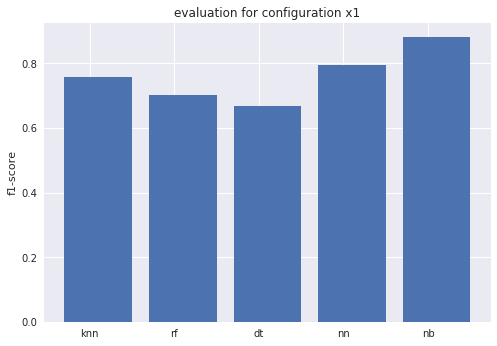

Testing for configuration 2
Analyse performance for pairing 1_2
Analyse performance for pairing 1_4


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 2_3


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 3_1


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 3_4


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 4_2
knn best pair: 3_1 (0.70428068800005539, 0.04867682446689757)
rf best pair: 1_2 (0.55744237690199827, 0.13936237154618805)
dt best pair: 1_4 (0.58492892021650544, 0.12376198837821167)
nn best pair: 3_1 (0.75546424395014611, 0.1356696821688391)
nb best pair: 3_1 (0.84035805193235913, 0.087971386228800921)



/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


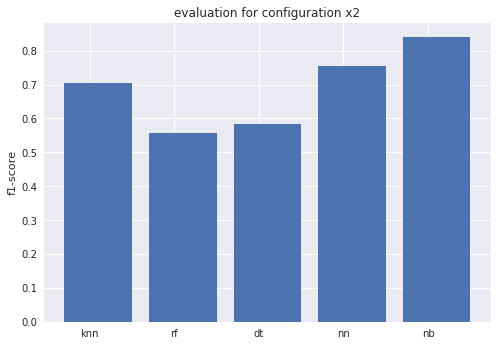

Testing for configuration 3
Analyse performance for pairing 1_2
Analyse performance for pairing 1_4
Analyse performance for pairing 2_3
Analyse performance for pairing 3_1


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 3_4
Analyse performance for pairing 4_2
knn best pair: 1_4 (0.71298937001561014, 0.10330467447240442)
rf best pair: 1_4 (0.76876492758301829, 0.17636423259247064)
dt best pair: 2_3 (0.68609059920928195, 0.16269379152276731)
nn best pair: 3_1 (0.81305303572238374, 0.067046834236178784)
nb best pair: 1_4 (0.89458224161238686, 0.068163464308074087)



/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


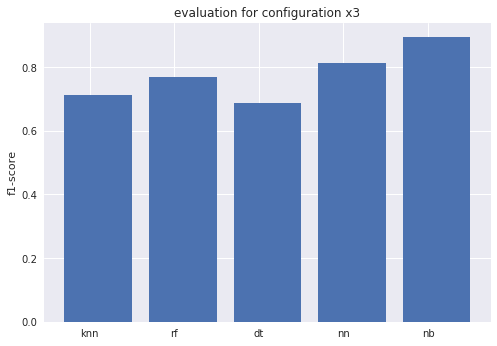

Testing for configuration 4
Analyse performance for pairing 1_2
Analyse performance for pairing 1_4


/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Analyse performance for pairing 2_3
Analyse performance for pairing 3_1
Analyse performance for pairing 3_4
Analyse performance for pairing 4_2
knn best pair: 3_4 (0.63586000599705805, 0.11126329174437624)
rf best pair: 2_3 (0.62498154668144068, 0.13832697309077641)
dt best pair: 3_1 (0.60960123411195821, 0.077066006733656406)
nn best pair: 2_3 (0.69288779874425954, 0.080438062695725732)
nb best pair: 3_4 (0.83682481635961536, 0.044367645522255125)



/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


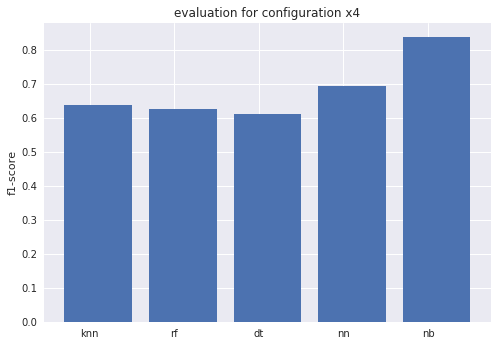

In [8]:
config = ['1','2','3','4']
pairing = ['1_2','1_4','2_3','3_1','3_4','4_2']
tst_ds = []
res_all = []

for c in config:
    results = {}
    print("Testing for configuration", c)
    for p in pairing:
        print("Analyse performance for pairing", p)
        res = evaluate_performance(c, p)
        res_all.append(res)

        #for model in res:
        #    print(model, res[model])
        results[p] = res
    draw_evaluation(c, results)

mean results with features from prepare_features() function:
mean F1 for knn:  0.6341062398202546
mean F1 for rf:  0.5659809964484108
mean F1 for dt:  0.5584082779239485
mean F1 for nn:  0.6581415629857549
mean F1 for nb:  0.7539057578388516



/gpfs/software/x86_64/anaconda/envs/anaconda431-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


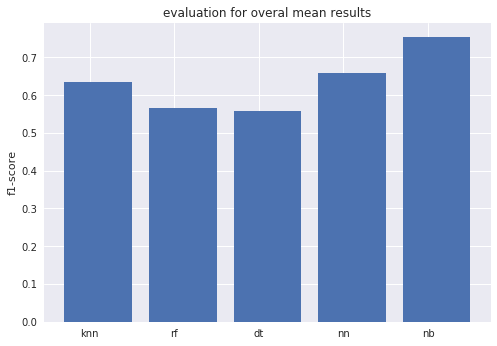

In [20]:
all_keys = set().union(*(d.keys() for d in res_all))
#print(all_keys)
mean_results=[]

print("mean results with features from prepare_features() function:")
for key in all_keys:
    mean_score = sum(item[key][0] for item in res_all)/len(res_all)
    print("mean F1 for {}:  {}".format(key, mean_score))
    mean_results.append(mean_score)
    

print()
xs = [i + 0.1 for i in range(len(all_keys))]    
plt.bar(xs, mean_results)
plt.ylabel("f1-score")
plt.title("evaluation for overal mean results")
plt.xticks([i for i in range(len(all_keys))], all_keys)
plt.show()


## Aufgabe 6: Online Erkenner

### Serialisierung des Models für den Online Predictor
Das zuvor gewählte Model wird serialisiert und in 'models/solution_ueb02' gespeichert damit es beim starten der REST-API geladen werden kann.

### Starten des online servers und simulieren der requests
#### Hierzu müssen die Abhängigkeiten Flask, flask_restful, flask_cors und requests installiert sein
The following command starts a flask_restful server on localhost port:5444 which answers json post requests. The server is implemented in the file online.py within the ipynb folder and makes use of the final chosen model.
Requests can be made as post request to http://localhost:5444/predict with a json file of the following format:
{ "row": "features" }
be careful that the sent file is valid json. The answer contains the predicted class.
{ "p_class": "predicted class" }
For now the online predictor only predicts the class of single lines sent to it

In [33]:
# Navigate to notebooks/solution_ueb02 and start the server
# with 'python -m online'

In [63]:
import requests
import pandas as pd
from filters import *
from utility import *
from features import *
# Nun werden zeilenweise Anfragen an die REST-API simuliert, jeder valider json request wird mit einer
# json prediction response beantwortet
# Hierzu benötigen wir ein vorbereitetes Test Data set
o_df = prepare_features('1', '1_2')[0]
o_df = o_df.dropna()
o_df = o_df.drop('target', axis=1)
url = 'http://localhost:5444/predict'

In [64]:
results = []
for index, elem in o_df.iterrows():
    r = requests.post(url, json={"data": elem.values.tolist()}) # request online predictor
    results.extend(r.json()['result']) # extending prediction result list
print(results)

['Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Present', 'Not Present', 'Present', 'Not Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Present', 'Not Present', 'Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Present', 'Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Not Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Present', 'Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Present', 'Present', 'Present', 'Present', 'Present', 'Present', 'Not Present', 'Present', 'Present', 'Present', 'Not Present', 'Not Present', 'Not Present', 'Not Present', 'No